In [41]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pyproj

# Add icedrift to the system path
sys.path.append('/Users/aless/Desktop/icedrift/src')

# Import necessary functions from icedrift
from icedrift.analysis import compute_velocity, compute_absolute_dispersion, compute_along_across_components
from icedrift.interpolation import interpolate_buoy_track

# Set plot style
sns.set(style="whitegrid")


In [42]:
# Define the directory containing the cleaned mosaic_dn1 buoy data
n_ice2015_data_dir = '../../data/buoy_data/n-ice2015/cleaned_data/'

# List all CSV files in the directory
mosaic_dn1_files = [f for f in os.listdir(n_ice2015_data_dir) if f.endswith('.csv')]

# Number of buoys to process
num_buoys = 25 # Adjust as needed

# Initialize an empty list to store DataFrames
buoy_data_list = []

# Load each CSV and append to the list
for file in mosaic_dn1_files[:num_buoys]:
    buoy_id = os.path.splitext(file)[0]  # Removes the .csv extension
    file_path = os.path.join(n_ice2015_data_dir, file)
    
    # Read CSV with 'datetime' parsed as datetime objects
    df = pd.read_csv(file_path, parse_dates=['datetime'])
    
    # Add buoy_id to the DataFrame
    df['buoy_id'] = buoy_id
    
    # Append to the list
    buoy_data_list.append(df)

# Concatenate all buoy DataFrames into a single DataFrame
all_buoy_data = pd.concat(buoy_data_list, ignore_index=True)

print(f"Loaded data for {all_buoy_data['buoy_id'].nunique()} buoys.")
print(all_buoy_data.head())


Loaded data for 25 buoys.
             datetime  longitude  latitude  qc   flag  \
0 2015-01-17 16:00:00    20.7078   83.2120   1  False   
1 2015-01-17 18:00:00    20.7622   83.2200   1  False   
2 2015-01-17 21:00:00    20.7542   83.2150   1  False   
3 2015-01-18 00:00:00    20.7592   83.2102   1  False   
4 2015-01-18 03:00:00    20.7674   83.2056   1  False   

                         buoy_id  
0  cleaned_n-ice2015_CALIB_2015d  
1  cleaned_n-ice2015_CALIB_2015d  
2  cleaned_n-ice2015_CALIB_2015d  
3  cleaned_n-ice2015_CALIB_2015d  
4  cleaned_n-ice2015_CALIB_2015d  


In [43]:
# Initialize a dictionary to store interpolated buoy data
buoy_data_interp = {}

# Get the list of unique buoy IDs
buoy_ids = all_buoy_data['buoy_id'].unique()

for buoy_id in buoy_ids:
    # Extract data for the current buoy
    buoy_df = all_buoy_data[all_buoy_data['buoy_id'] == buoy_id].copy()
    
    # Ensure the DataFrame is sorted by datetime
    buoy_df = buoy_df.sort_values('datetime').reset_index(drop=True)
    
    # Set 'datetime' as the index
    buoy_df.set_index('datetime', inplace=True)
    
    # Interpolate buoy track to hourly frequency with a maximum gap of 4 hours (240 minutes)
    interpolated_df = interpolate_buoy_track(
        buoy_df, 
        freq='1h',  # Hourly frequency
        maxgap_minutes=240  # Maximum gap of 4 hours
    ).loc[:, ['longitude', 'latitude']]  # Select relevant columns
    
    # Add buoy_id back to the interpolated DataFrame
    interpolated_df['buoy_id'] = buoy_id
    
    # Store in the dictionary
    buoy_data_interp[buoy_id] = interpolated_df

print("Interpolated buoy data to hourly frequency.")


Interpolated buoy data to hourly frequency.


In [44]:
# Initialize a dictionary to store daily resampled data with velocity
buoy_data_daily = {}

for buoy_id, df in buoy_data_interp.items():
    # Resample to daily frequency at 12:00 UTC
    # '24h' frequency starting from the first timestamp
    daily = df.resample('24h', origin='start').asfreq().dropna()
    
    # Compute velocities
    # Assuming 'compute_velocity' requires the DataFrame to have 'longitude' and 'latitude' columns
    # and that it adds 'u', 'v', and 'speed' columns
    daily = compute_velocity(daily, date_index=True, rotate_uv=False, method='c')
    
    # Add buoy_id to the daily DataFrame
    daily['buoy_id'] = buoy_id
    
    # Store in the dictionary
    buoy_data_daily[buoy_id] = daily

print("Velocity computation complete.")
print("Resampled buoy data to daily frequency at 12:00 UTC.")


Velocity computation complete.
Resampled buoy data to daily frequency at 12:00 UTC.


In [45]:
import pyproj
import pandas as pd
import numpy as np
import xarray as xr

def sic_along_track(position_data, sic_data):
    """
    Uses xarray advanced interpolation to get along-track SIC via nearest neighbors.
    
    Parameters:
    - position_data: DataFrame with 'datetime', 'longitude', 'latitude'
    - sic_data: xarray Dataset with 'sea_ice_concentration'
    
    Returns:
    - pandas Series with SIC values aligned to position_data index
    """
    # Coordinate reference systems
    crs0 = pyproj.CRS('WGS84')  # Original coordinate system (longitude, latitude)
    crs1 = pyproj.CRS(
        '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 '
        '+k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs'
    )  # Target NSIDC NP Stereographic system
    
    # Transformer for converting coordinates
    transformer_stere = pyproj.Transformer.from_crs(crs0, crs1, always_xy=True)
    
    # Initialize an empty Series for SIC values
    sic = pd.Series(data=np.nan, index=position_data.index)
    
    # Process each unique date in the position data
    for date, group in position_data.groupby(position_data['datetime'].dt.date):
        # Convert geographic coordinates to stereographic projection
        x_stere, y_stere = transformer_stere.transform(group['longitude'].values, group['latitude'].values)
        
        # Create xarray DataArrays for interpolation
        x = xr.DataArray(x_stere, dims="z")
        y = xr.DataArray(y_stere, dims="z")
        
        # Select SIC data for the current date and interpolate
        SIC = sic_data.sel(time=date.strftime('%Y-%m-%d'))['sea_ice_concentration'].interp(
            {'x': x, 'y': y}, method='nearest').data
        
        # Assign interpolated SIC values back to the appropriate indices in the SIC Series
        sic.loc[group.index] = np.round(SIC, 3)  # Transpose removed as it may not be necessary
        
    # Replace SIC values greater than 100 with NaN (to handle outliers)
    sic[sic > 100] = np.nan
    return sic


# Load SIC data
sic_file = '../../NSIDC Sea Ice Concentration/nsidc_daily_sic_cdr_2015.nc'
sic_data = xr.open_dataset(sic_file)

# Reformat NSIDC data for convenience with interpolation -- rename coordinates and dimensions
ds = xr.Dataset({
    'sea_ice_concentration': (('time', 'y', 'x'), sic_data['cdr_seaice_conc'].data)
},
coords={
    'time': ('time', pd.to_datetime(sic_data.time.data)),
    'x': ('x', sic_data['xgrid'].data),
    'y': ('y', sic_data['ygrid'].data)
})

print("Loaded and reformatted SIC data.")
print(f"SIC data coordinate range: x [{sic_data['xgrid'].min().values}, {sic_data['xgrid'].max().values}], "
      f"y [{sic_data['ygrid'].min().values}, {sic_data['ygrid'].max().values}]")
# print(f"Buoy data coordinate range: longitude [{all_positions_daily['longitude'].min()}, {all_positions_daily['longitude'].max()}], "
#       f"latitude [{all_positions_daily['latitude'].min()}, {all_positions_daily['latitude'].max()}]")



Loaded and reformatted SIC data.
SIC data coordinate range: x [-3837500.0, 3737500.0], y [-5337500.0, 5837500.0]


In [46]:
# Concatenate all buoy data into a single DataFrame
all_positions_daily = pd.concat(buoy_data_daily.values())

# Reset index to make 'datetime' a column
all_positions_daily.reset_index(inplace=True)

print("Combined all buoys into all_positions_daily.")
print(all_positions_daily.head())
print(all_positions_daily.columns)


Combined all buoys into all_positions_daily.
             datetime  longitude  latitude                        buoy_id  \
0 2015-01-17 16:00:00   20.70780  83.21200  cleaned_n-ice2015_CALIB_2015d   
1 2015-01-18 16:00:00   20.78310  83.18782  cleaned_n-ice2015_CALIB_2015d   
2 2015-01-19 16:00:00   20.85093  83.20953  cleaned_n-ice2015_CALIB_2015d   
3 2015-01-20 16:00:00   20.40127  83.17596  cleaned_n-ice2015_CALIB_2015d   
4 2015-01-21 16:00:00   20.49785  83.19313  cleaned_n-ice2015_CALIB_2015d   

               x              y         u         v     speed  
0  670972.910044 -302845.926925       NaN       NaN       NaN  
1  673767.281722 -303041.928931  0.005784  0.009070  0.010757  
2  671972.328364 -301278.668282 -0.004990 -0.029051  0.029476  
3  672904.947979 -308061.897151 -0.001431 -0.028209  0.028245  
4  671725.032911 -306153.175701 -0.002162  0.042602  0.042656  
Index(['datetime', 'longitude', 'latitude', 'buoy_id', 'x', 'y', 'u', 'v',
       'speed'],
      dtype='obj

In [47]:
# Define the desired date range within SIC data range
start_date = pd.Timestamp('2015-01-01')
end_date = pd.Timestamp('2015-05-31')

# Filter all_positions_daily to only include dates within this range
all_positions_daily = all_positions_daily[
    (all_positions_daily['datetime'] >= start_date) &
    (all_positions_daily['datetime'] <= end_date)
]

# Verify the filtered date range
print("Filtered buoy data date range:", all_positions_daily['datetime'].min(), "to", all_positions_daily['datetime'].max())


# Apply the SIC extraction function to obtain sea ice concentration values along the track
all_positions_daily['sea_ice_concentration'] = sic_along_track(all_positions_daily, ds)


# Check the results to verify that SIC values have been assigned without excessive NaNs
print(all_positions_daily[['datetime', 'longitude', 'latitude', 'sea_ice_concentration']].head())
print(f"Total NaN values in 'sea_ice_concentration': {all_positions_daily['sea_ice_concentration'].isna().sum()}")


Filtered buoy data date range: 2015-01-16 06:00:00 to 2015-05-30 17:00:00
             datetime  longitude  latitude  sea_ice_concentration
0 2015-01-17 16:00:00   20.70780  83.21200                   0.99
1 2015-01-18 16:00:00   20.78310  83.18782                   1.00
2 2015-01-19 16:00:00   20.85093  83.20953                   0.99
3 2015-01-20 16:00:00   20.40127  83.17596                   0.97
4 2015-01-21 16:00:00   20.49785  83.19313                   0.96
Total NaN values in 'sea_ice_concentration': 0


In [48]:
# Interpolate missing 'speed' values
all_positions_daily['speed'] = all_positions_daily['speed'].interpolate(method='linear')

# Forward fill any remaining NaNs
all_positions_daily['speed'] = all_positions_daily['speed'].fillna(method='ffill').fillna(method='bfill')

# Check the total number of NaNs in the 'speed' column
total_speed_nans = all_positions_daily['speed'].isna().sum()
print(f"Total NaN values in 'speed': {total_speed_nans}")

# Identify datetime groups where all 'speed' values are NaN
speed_nan_groups = all_positions_daily.groupby('datetime')['speed'].apply(lambda x: x.isna().all())
nan_dates = speed_nan_groups[speed_nan_groups].index.tolist()

print(f"Dates with all 'speed' values as NaN: {nan_dates}")

# Display rows where 'speed' is NaN
nan_speed_rows = all_positions_daily[all_positions_daily['speed'].isna()]
print("Rows with NaN 'speed' values:")
print(nan_speed_rows)


Total NaN values in 'speed': 0
Dates with all 'speed' values as NaN: []
Rows with NaN 'speed' values:
Empty DataFrame
Columns: [datetime, longitude, latitude, buoy_id, x, y, u, v, speed, sea_ice_concentration]
Index: []


/var/folders/lm/jq7cgq_91z98cg7sw6wybytw0000gn/T/ipykernel_5722/941635688.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_positions_daily['speed'] = all_positions_daily['speed'].fillna(method='ffill').fillna(method='bfill')


In [49]:


# Set SIC > 1 to NaN
all_positions_daily.loc[all_positions_daily['sea_ice_concentration'] > 1, 'sea_ice_concentration'] = np.nan


# Verify the cleaning process
num_nan_sic = all_positions_daily['sea_ice_concentration'].isna().sum()
print(f"Number of SIC values set to NaN: {num_nan_sic}")

# Ensure no SIC values >1 remain
max_sic = all_positions_daily['sea_ice_concentration'].max()
print(f"Maximum SIC after cleaning: {max_sic}")

# Assertion to ensure data integrity
assert max_sic <= 1 or pd.isna(max_sic), "There are SIC values greater than 1 that are not set to NaN."


Number of SIC values set to NaN: 0
Maximum SIC after cleaning: 1.0


In [50]:
# Check if 'datetime' is already the index, then reset if needed
if 'datetime' not in all_positions_daily.columns and 'datetime' in all_positions_daily.index.names:
    all_positions_daily.reset_index(inplace=True)

# Ensure 'datetime' is in datetime format
all_positions_daily['datetime'] = pd.to_datetime(all_positions_daily['datetime'])

# Create a copy of 'datetime' to keep as a separate column
all_positions_daily['datetime_copy'] = all_positions_daily['datetime']

# Set 'datetime' as the index for resampling and rolling operations
all_positions_daily.set_index('datetime', inplace=True)



# Reset the index to avoid conflicts with duplicate labels for rolling calculation
all_positions_daily_reset = all_positions_daily.reset_index()

# Group by 'buoy_id' and calculate rolling mean and anomaly
all_positions_daily_reset['rolling_mean_speed'] = all_positions_daily_reset.groupby('buoy_id')['speed'].rolling(
    window=24, center=True, min_periods=1).mean().reset_index(level=0, drop=True)
all_positions_daily_reset['speed_anomaly'] = all_positions_daily_reset['speed'] - all_positions_daily_reset['rolling_mean_speed']

# Set 'datetime' as the index again
all_positions_daily = all_positions_daily_reset.set_index('datetime')



In [51]:
# Resample to daily frequency and compute statistics
daily_median_anomaly = all_positions_daily['speed_anomaly'].resample('D').median()
daily_min_anomaly = all_positions_daily['speed_anomaly'].resample('D').min()
daily_max_anomaly = all_positions_daily['speed_anomaly'].resample('D').max()

# Verify the results
print(daily_median_anomaly.head())
print(daily_min_anomaly.head())
print(daily_max_anomaly.head())



datetime
2015-01-16    0.005138
2015-01-17   -0.033773
2015-01-18   -0.048429
2015-01-19   -0.046532
2015-01-20   -0.033093
Freq: D, Name: speed_anomaly, dtype: float64
datetime
2015-01-16   -0.006595
2015-01-17   -0.051407
2015-01-18   -0.061335
2015-01-19   -0.059105
2015-01-20   -0.043937
Freq: D, Name: speed_anomaly, dtype: float64
datetime
2015-01-16    0.016871
2015-01-17   -0.029160
2015-01-18   -0.033132
2015-01-19   -0.031480
2015-01-20   -0.028753
Freq: D, Name: speed_anomaly, dtype: float64


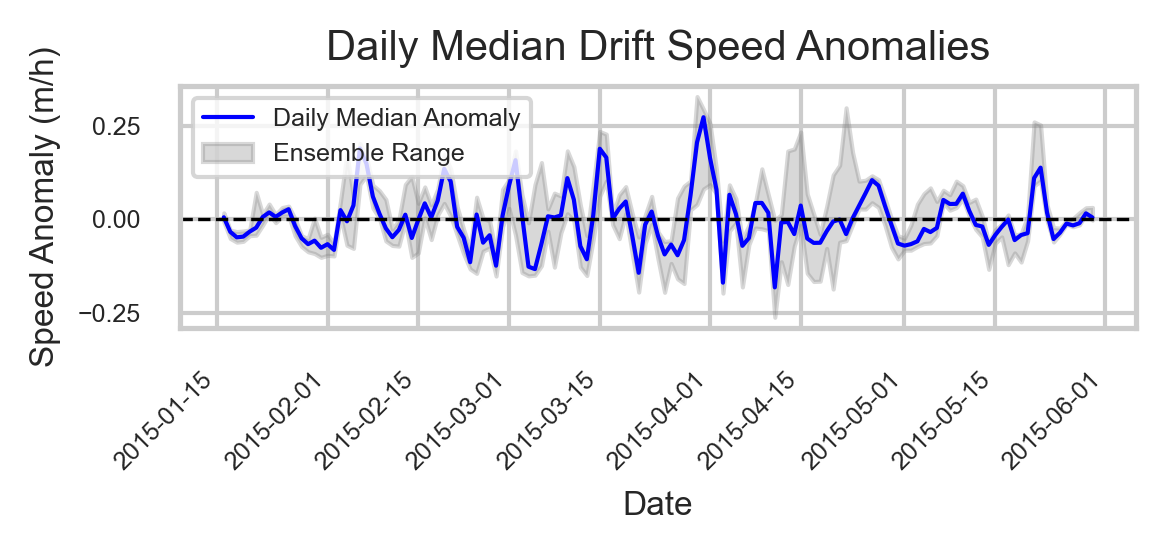

Median of daily median anomalies: -0.007 m/h


In [52]:
import matplotlib.pyplot as plt

# Set up a smaller figure size for a compact layout with higher resolution
plt.figure(figsize=(4, 2), dpi=300)  # Very compact size with high DPI for sharpness

# Plot the daily median anomaly
plt.plot(daily_median_anomaly.index, daily_median_anomaly, label='Daily Median Anomaly', color='blue', linewidth=1)

# Plot the ensemble range as a shaded area
plt.fill_between(
    daily_median_anomaly.index,
    daily_min_anomaly,
    daily_max_anomaly,
    color='gray',
    alpha=0.3,
    label='Ensemble Range'
)

# Add a zero line for reference
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Axis labels with smaller font sizes for compactness
plt.xlabel('Date', fontsize=8)
plt.ylabel('Speed Anomaly (m/h)', fontsize=8)

# Set a smaller title to fit within the small figure
plt.title('Daily Median Drift Speed Anomalies', fontsize=10)

# Rotate x-axis date labels and align them for better readability
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=6)

# Adjust legend font size and placement for compactness
plt.legend(fontsize=6, loc='upper left')

# Tighten the layout even further
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and display the median of daily median anomalies
median_of_medians = daily_median_anomaly.median()
print(f"Median of daily median anomalies: {median_of_medians:.3f} m/h")



In [53]:

drift_speed_stats = all_positions_daily.resample('D').agg(
    median_speed=('speed', 'median'),
    IQR_lower_speed=('speed', lambda x: x.quantile(0.25)),
    IQR_upper_speed=('speed', lambda x: x.quantile(0.75))
).reset_index()

sic_stats = all_positions_daily.resample('D').agg(
    median_sic=('sea_ice_concentration', 'median'),
    IQR_lower_sic=('sea_ice_concentration', lambda x: x.quantile(0.25)),
    IQR_upper_sic=('sea_ice_concentration', lambda x: x.quantile(0.75))
).reset_index()

print("Statistical calculations complete.")
print(drift_speed_stats.head())
print(sic_stats.head())


Statistical calculations complete.
    datetime  median_speed  IQR_lower_speed  IQR_upper_speed
0 2015-01-16      0.077015         0.071491         0.082539
1 2015-01-17      0.037609         0.024183         0.040715
2 2015-01-18      0.018771         0.011993         0.027551
3 2015-01-19      0.024828         0.019829         0.027993
4 2015-01-20      0.035516         0.032393         0.037578
    datetime  median_sic  IQR_lower_sic  IQR_upper_sic
0 2015-01-16       1.000         1.0000          1.000
1 2015-01-17       0.990         0.9850          0.995
2 2015-01-18       0.995         0.9875          1.000
3 2015-01-19       0.985         0.9775          0.990
4 2015-01-20       0.965         0.9575          0.970


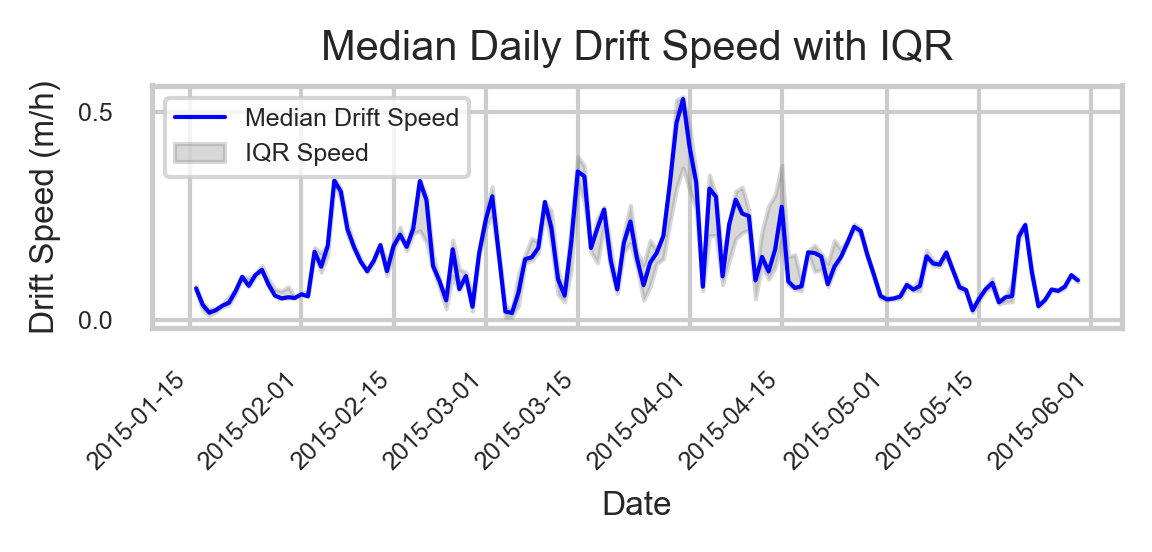

In [54]:
import matplotlib.pyplot as plt

# Set up a smaller figure size for compact layout with higher resolution
plt.figure(figsize=(4, 2), dpi=300)

# Plot the median drift speed
plt.plot(drift_speed_stats['datetime'], drift_speed_stats['median_speed'], label='Median Drift Speed', color='blue', linewidth=1)

# Plot the IQR range as a shaded area
plt.fill_between(
    drift_speed_stats['datetime'],
    drift_speed_stats['IQR_lower_speed'],
    drift_speed_stats['IQR_upper_speed'],
    color="gray",
    alpha=0.3,
    label='IQR Speed'
)

# Axis labels and title with smaller font sizes
plt.xlabel('Date', fontsize=8)
plt.ylabel('Drift Speed (m/h)', fontsize=8)
plt.title('Median Daily Drift Speed with IQR', fontsize=10)

# Rotate x-axis date labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=6)

# Adjust legend font size and placement for compactness
plt.legend(fontsize=6, loc='upper left')

# Tighten layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()




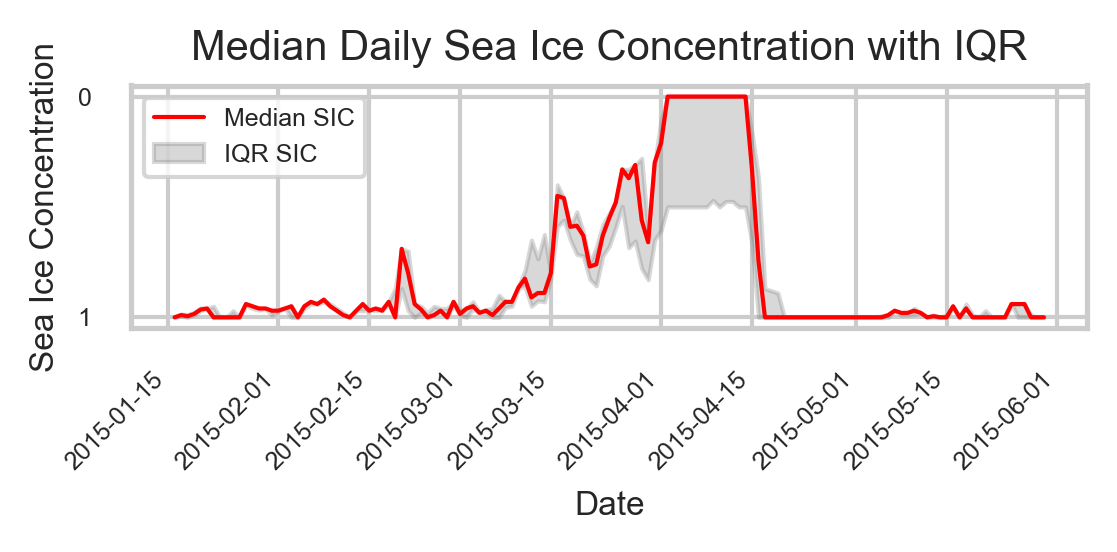

In [55]:
import matplotlib.pyplot as plt

# Set up a smaller figure size for compact layout with higher resolution
plt.figure(figsize=(4, 2), dpi=300)

# Plot the median sea ice concentration
plt.plot(sic_stats['datetime'], sic_stats['median_sic'], label='Median SIC', color='red', linewidth=1)

# Plot the IQR range as a shaded area
plt.fill_between(
    sic_stats['datetime'],
    sic_stats['IQR_lower_sic'],
    sic_stats['IQR_upper_sic'],
    color="gray",
    alpha=0.3,
    label='IQR SIC'
)

# Axis labels and title with smaller font sizes
plt.xlabel('Date', fontsize=8)
plt.ylabel('Sea Ice Concentration', fontsize=8)
plt.title('Median Daily Sea Ice Concentration with IQR', fontsize=10)

# Rotate x-axis date labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=6)

# Adjust legend font size and placement for compactness
plt.legend(fontsize=6, loc='upper left')

# Invert y-axis if higher SIC values represent more ice (optional)
plt.gca().invert_yaxis()

# Tighten layout for a cleaner look
plt.tight_layout()

# Show the plot
plt.show()


Index(['longitude', 'latitude', 'buoy_id', 'x', 'y', 'u', 'v', 'speed',
       'sea_ice_concentration', 'datetime_copy', 'rolling_mean_speed',
       'speed_anomaly'],
      dtype='object')


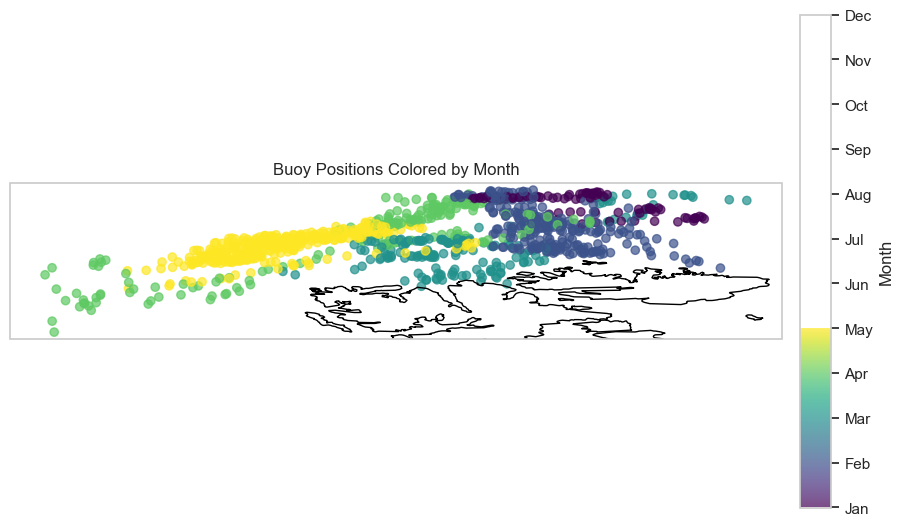

In [56]:
print(all_positions_daily.columns)

# Extract month from datetime
all_positions_daily['month'] = all_positions_daily['datetime_copy'].dt.month
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define a color palette for months
cmap = plt.get_cmap('viridis', 12)  # 12 discrete colors for 12 months

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Scatter plot colored by month
scatter = ax.scatter(
    all_positions_daily['longitude'], 
    all_positions_daily['latitude'],
    c=all_positions_daily['month'],
    cmap='viridis',
    alpha=0.7,
    transform=ccrs.PlateCarree()
)

# Add colorbar with month labels
cbar = plt.colorbar(scatter, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
cbar.set_label('Month')
cbar.set_ticks(range(1,13))
cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.title('Buoy Positions Colored by Month')
plt.show()


In [57]:
# Calculate median geographic position
median_lat = all_positions_daily['latitude'].median()
median_lon = all_positions_daily['longitude'].median()

print(f"Median Latitude: {median_lat}, Median Longitude: {median_lon}")

# Define a geographic window (e.g., ±1 degree)
window = 1.0  # degrees

median_region = all_positions_daily[
    (all_positions_daily['latitude'] >= median_lat - window) &
    (all_positions_daily['latitude'] <= median_lat + window) &
    (all_positions_daily['longitude'] >= median_lon - window) &
    (all_positions_daily['longitude'] <= median_lon + window)
]

print(f"Number of data points in median region: {len(median_region)}")

# Check if wind data exists
if 'wind_speed' in median_region.columns and 'wind_direction' in median_region.columns:
    # Convert wind direction to u and v components
    median_region['u'] = median_region['wind_speed'] * np.cos(np.deg2rad(median_region['wind_direction']))
    median_region['v'] = median_region['wind_speed'] * np.sin(np.deg2rad(median_region['wind_direction']))
    
    # Plot quiver (vector) plot
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    quiver = ax.quiver(
        median_region['longitude'], 
        median_region['latitude'],
        median_region['u'], 
        median_region['v'],
        median_region['wind_speed'],
        cmap='cool',
        scale=50,
        transform=ccrs.PlateCarree()
    )
    
    # Add colorbar
    cbar = plt.colorbar(quiver, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
    cbar.set_label('Wind Speed (m/s)')
    
    plt.title('Wind Vectors Along Median Position')
    plt.show()
else:
    print("Wind data ('wind_speed' and 'wind_direction') not found in the DataFrame.")



Median Latitude: 81.55466, Median Longitude: 14.707405000000001
Number of data points in median region: 82
Wind data ('wind_speed' and 'wind_direction') not found in the DataFrame.


In [58]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_combined_anomalies_and_sic(daily_median, daily_min, daily_max, drift_stats, sic_stats, expedition_id):
    """
    Plots Daily Median Drift Speed Anomalies, Drift Speed with IQR, and Sea Ice Concentration with IQR
    in a single figure with three subplots.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), dpi=300, sharex=True)

    # Daily Median Drift Speed Anomalies
    ax1.plot(daily_median.index, daily_median, label='Daily Median Anomaly', color='blue', linewidth=1)
    ax1.fill_between(
        daily_median.index,
        daily_min,
        daily_max,
        color='gray',
        alpha=0.3,
        label='Ensemble Range'
    )
    ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax1.set_ylabel('Speed Anomaly (m/h)', fontsize=8)
    ax1.set_title(f'Daily Median Drift Speed Anomalies - {expedition_id}', fontsize=10)
    ax1.legend(fontsize=6, loc='upper left')
    ax1.tick_params(axis='y', labelsize=6)

    # Drift Speed with IQR
    color = 'tab:blue'
    ax2.plot(drift_stats['datetime'], drift_stats['median_speed'], label='Median Drift Speed', color=color, linewidth=1)
    ax2.fill_between(
        drift_stats['datetime'],
        drift_stats['IQR_lower_speed'],
        drift_stats['IQR_upper_speed'],
        color="gray",
        alpha=0.3,
        label='IQR Speed'
    )
    ax2.set_ylabel('Drift Speed (m/h)', fontsize=8)
    ax2.set_title('Median Daily Drift Speed with IQR', fontsize=10)
    ax2.legend(fontsize=6, loc='upper left')
    ax2.tick_params(axis='y', labelsize=6)

    # Sea Ice Concentration with IQR
    color = 'tab:red'
    ax3.plot(sic_stats['datetime'], sic_stats['median_sic'], label='Median SIC', color=color, linewidth=1)
    ax3.fill_between(
        sic_stats['datetime'],
        sic_stats['IQR_lower_sic'],
        sic_stats['IQR_upper_sic'],
        color=color,
        alpha=0.3,
        label='IQR SIC'
    )
    ax3.set_ylabel('Sea Ice Concentration', fontsize=8)
    ax3.set_title('Median Daily Sea Ice Concentration with IQR', fontsize=10)
    ax3.legend(fontsize=6, loc='upper left')
    ax3.invert_yaxis()  # Invert y-axis if higher SIC indicates more ice
    ax3.tick_params(axis='y', labelsize=6)

    # Common x-axis label
    ax3.set_xlabel('Date', fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=6)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_monthly_colored_map(df, title):
    """
    Plots buoy tracks with 12 distinct colors, one for each month, using the 'viridis' colormap.
    """
    # Ensure the month column is set correctly
    if 'datetime' in df.columns:
        df['month'] = df['datetime'].dt.month  # Adjust if 'datetime' is the correct column
    elif 'datetime_copy' in df.columns:
        df['month'] = df['datetime_copy'].dt.month
    else:
        raise KeyError("Neither 'datetime' nor 'datetime_copy' column found in DataFrame.")

    # Set a larger figure size for better visual alignment with the previous layout
    plt.figure(figsize=(12, 8), dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Scatter plot of buoy positions colored by month
    scatter = ax.scatter(
        df['longitude'], 
        df['latitude'],
        c=df['month'],
        cmap='viridis',  # 'viridis' colormap with 12 discrete colors for months
        alpha=0.7,
        transform=ccrs.PlateCarree()
    )
    
    # Add a color bar with month labels
    cbar = plt.colorbar(scatter, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
    cbar.set_label('Month', fontsize=10)
    cbar.set_ticks(range(1, 13))
    cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    # Set title and show plot
    plt.title(title, fontsize=12)
    plt.show()


def plot_nps_map(df, title):
    """
    Plots buoy tracks with a North Polar Stereographic projection, with colors indicating the month.
    
    Parameters:
    - df: DataFrame containing 'longitude', 'latitude', and 'month' columns
    - title: Title for the plot
    """
    # Ensure month is extracted
    if 'datetime' in df.columns:
        df['month'] = df['datetime'].dt.month
    elif 'datetime_copy' in df.columns:
        df['month'] = df['datetime_copy'].dt.month
    else:
        raise KeyError("Neither 'datetime' nor 'datetime_copy' column found in DataFrame.")
    
    # Set up North Polar Stereographic projection
    crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
    fig, ax = plt.subplots(figsize=(6, 8), dpi=300, subplot_kw={'projection': crs})

    # Set the extent to focus on the Arctic region
    ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    
    # Plot with colors by month
    scatter = ax.scatter(
        df['longitude'], df['latitude'],
        c=df['month'], cmap='viridis', s=10, alpha=0.7,
        transform=ccrs.PlateCarree()
    )

    # Color bar indicating months
    cbar = plt.colorbar(scatter, orientation='vertical', pad=0.02, aspect=16, shrink=0.8)
    cbar.set_label('Month', fontsize=10)
    cbar.set_ticks(range(1, 13))
    cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.title(title, fontsize=12)
    plt.show()

# Example usage:
# plot_combined_anomalies_and_sic(...)
# plot_monthly_colored_map(all_positions_daily, 'Buoy Positions Colored by Month')
# plot_nps_map(all_positions_daily, 'Buoy Tracks in North Polar Stereographic Projection')




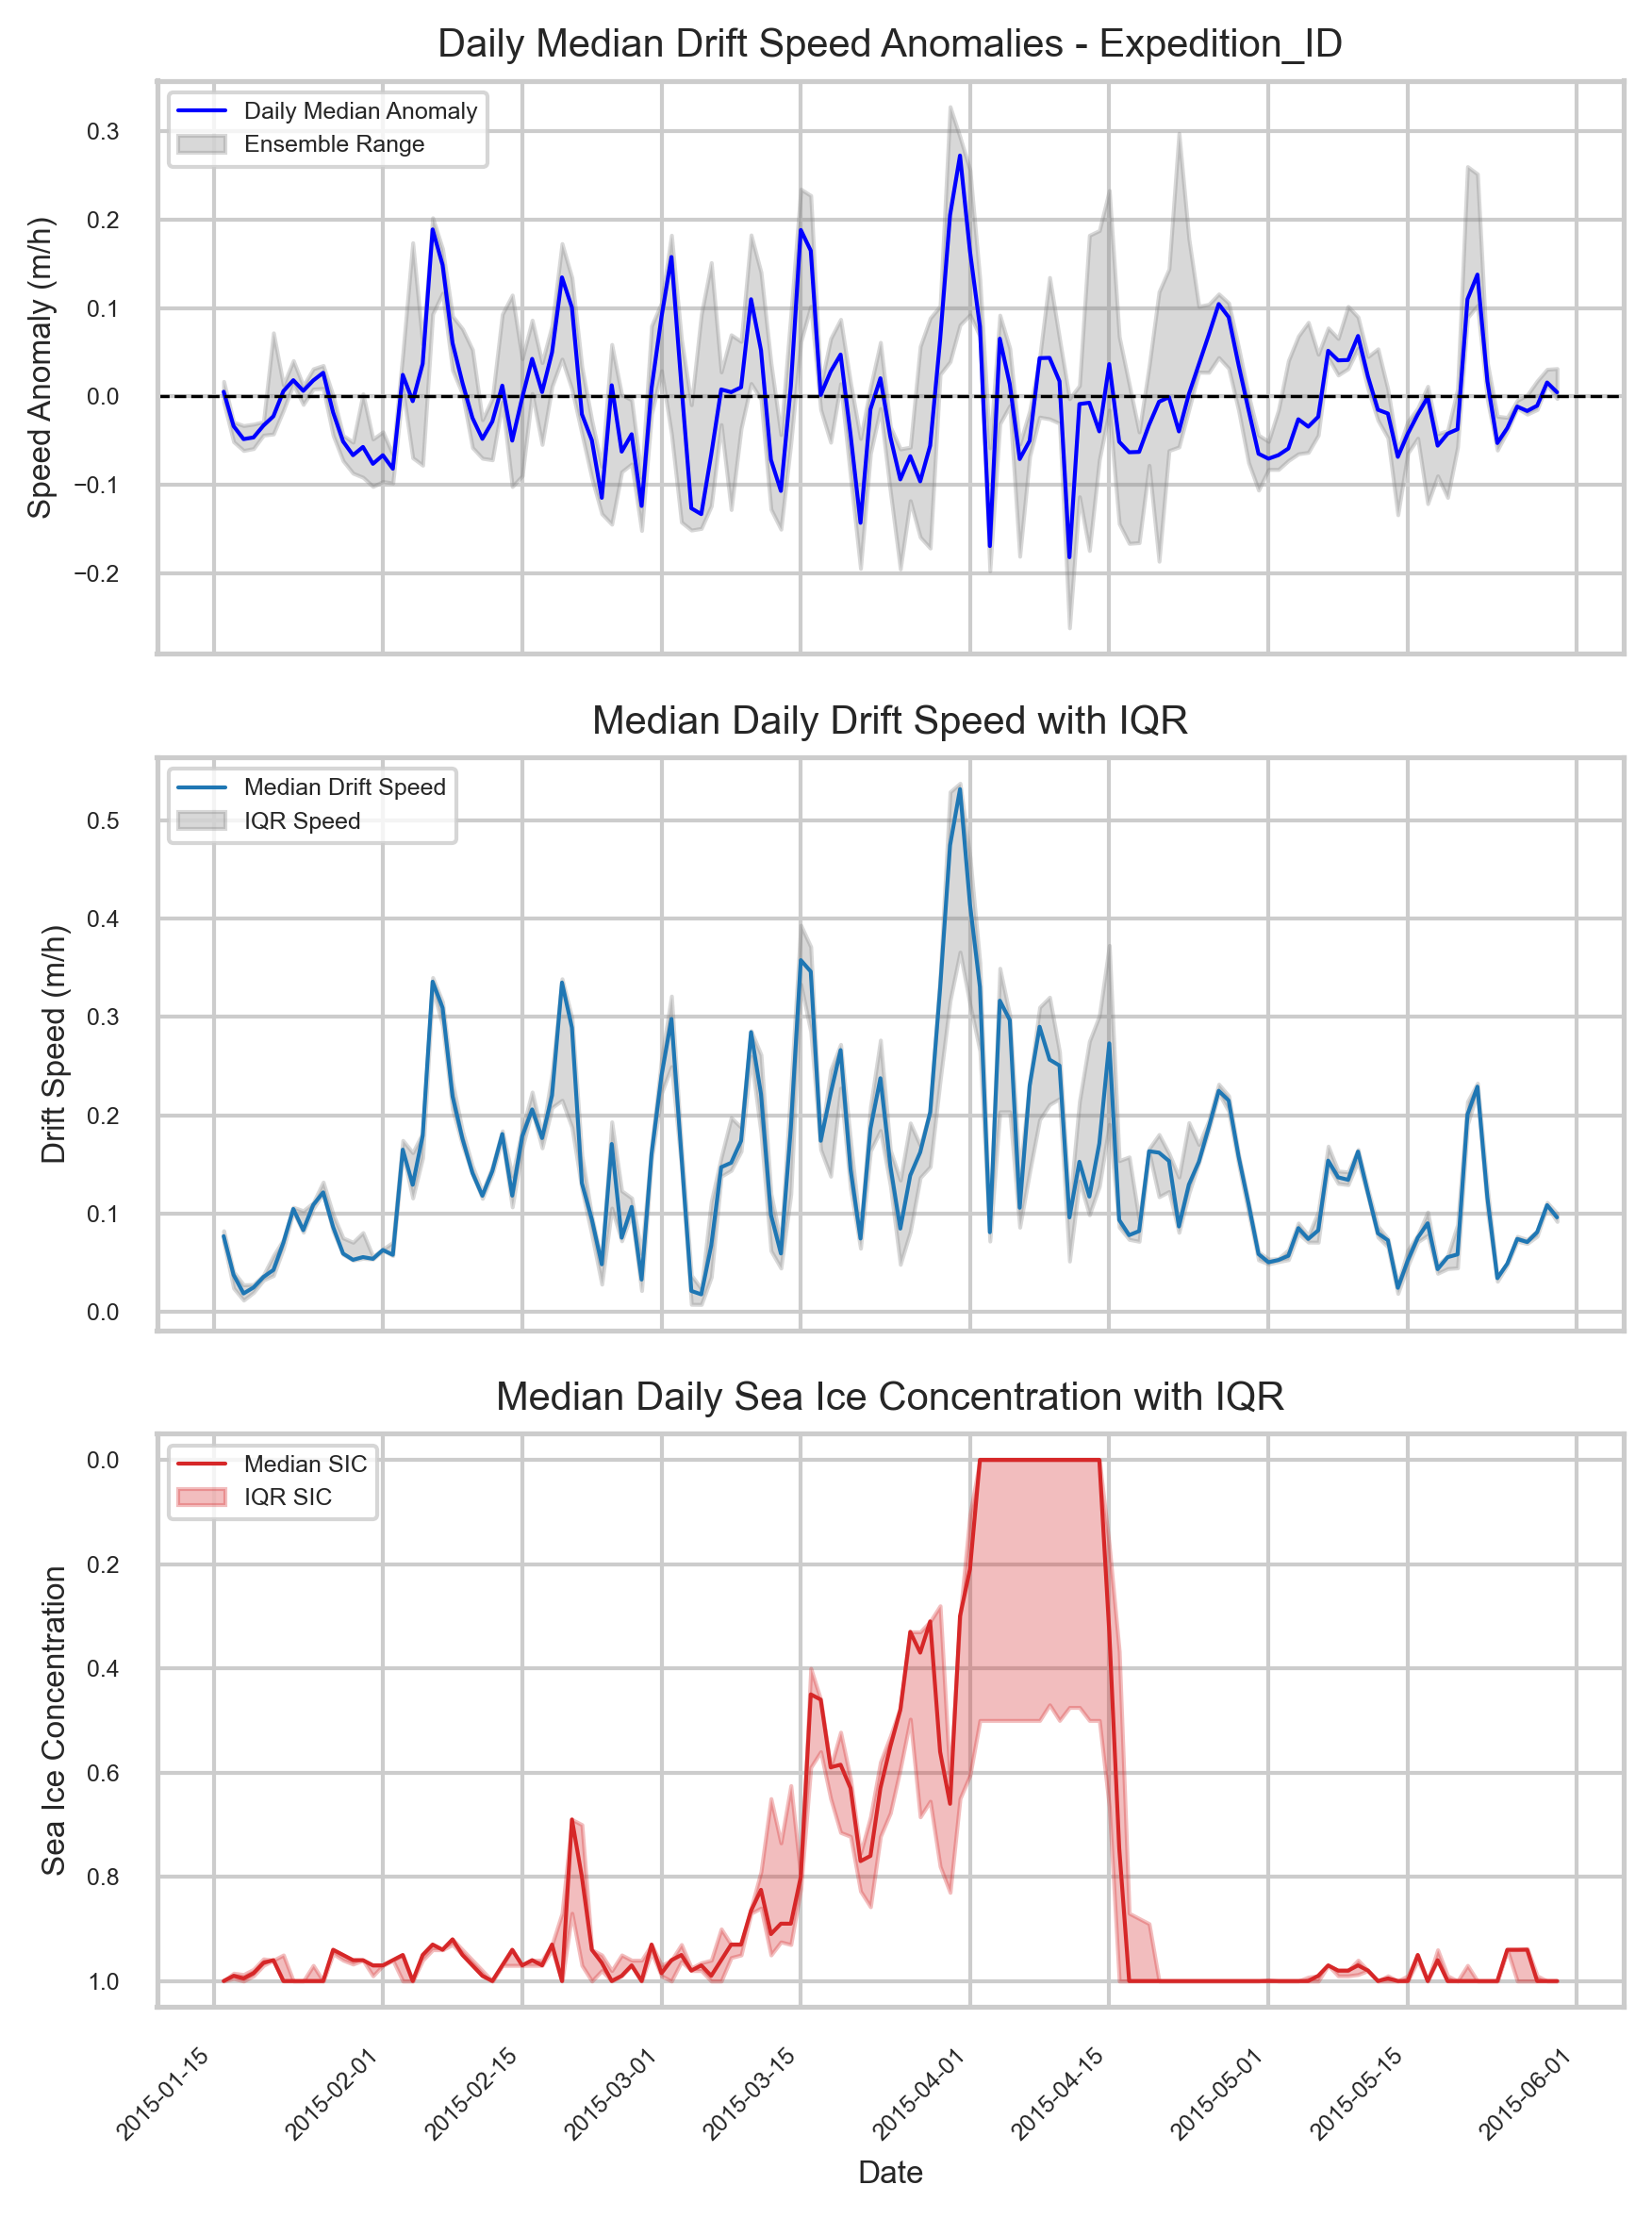

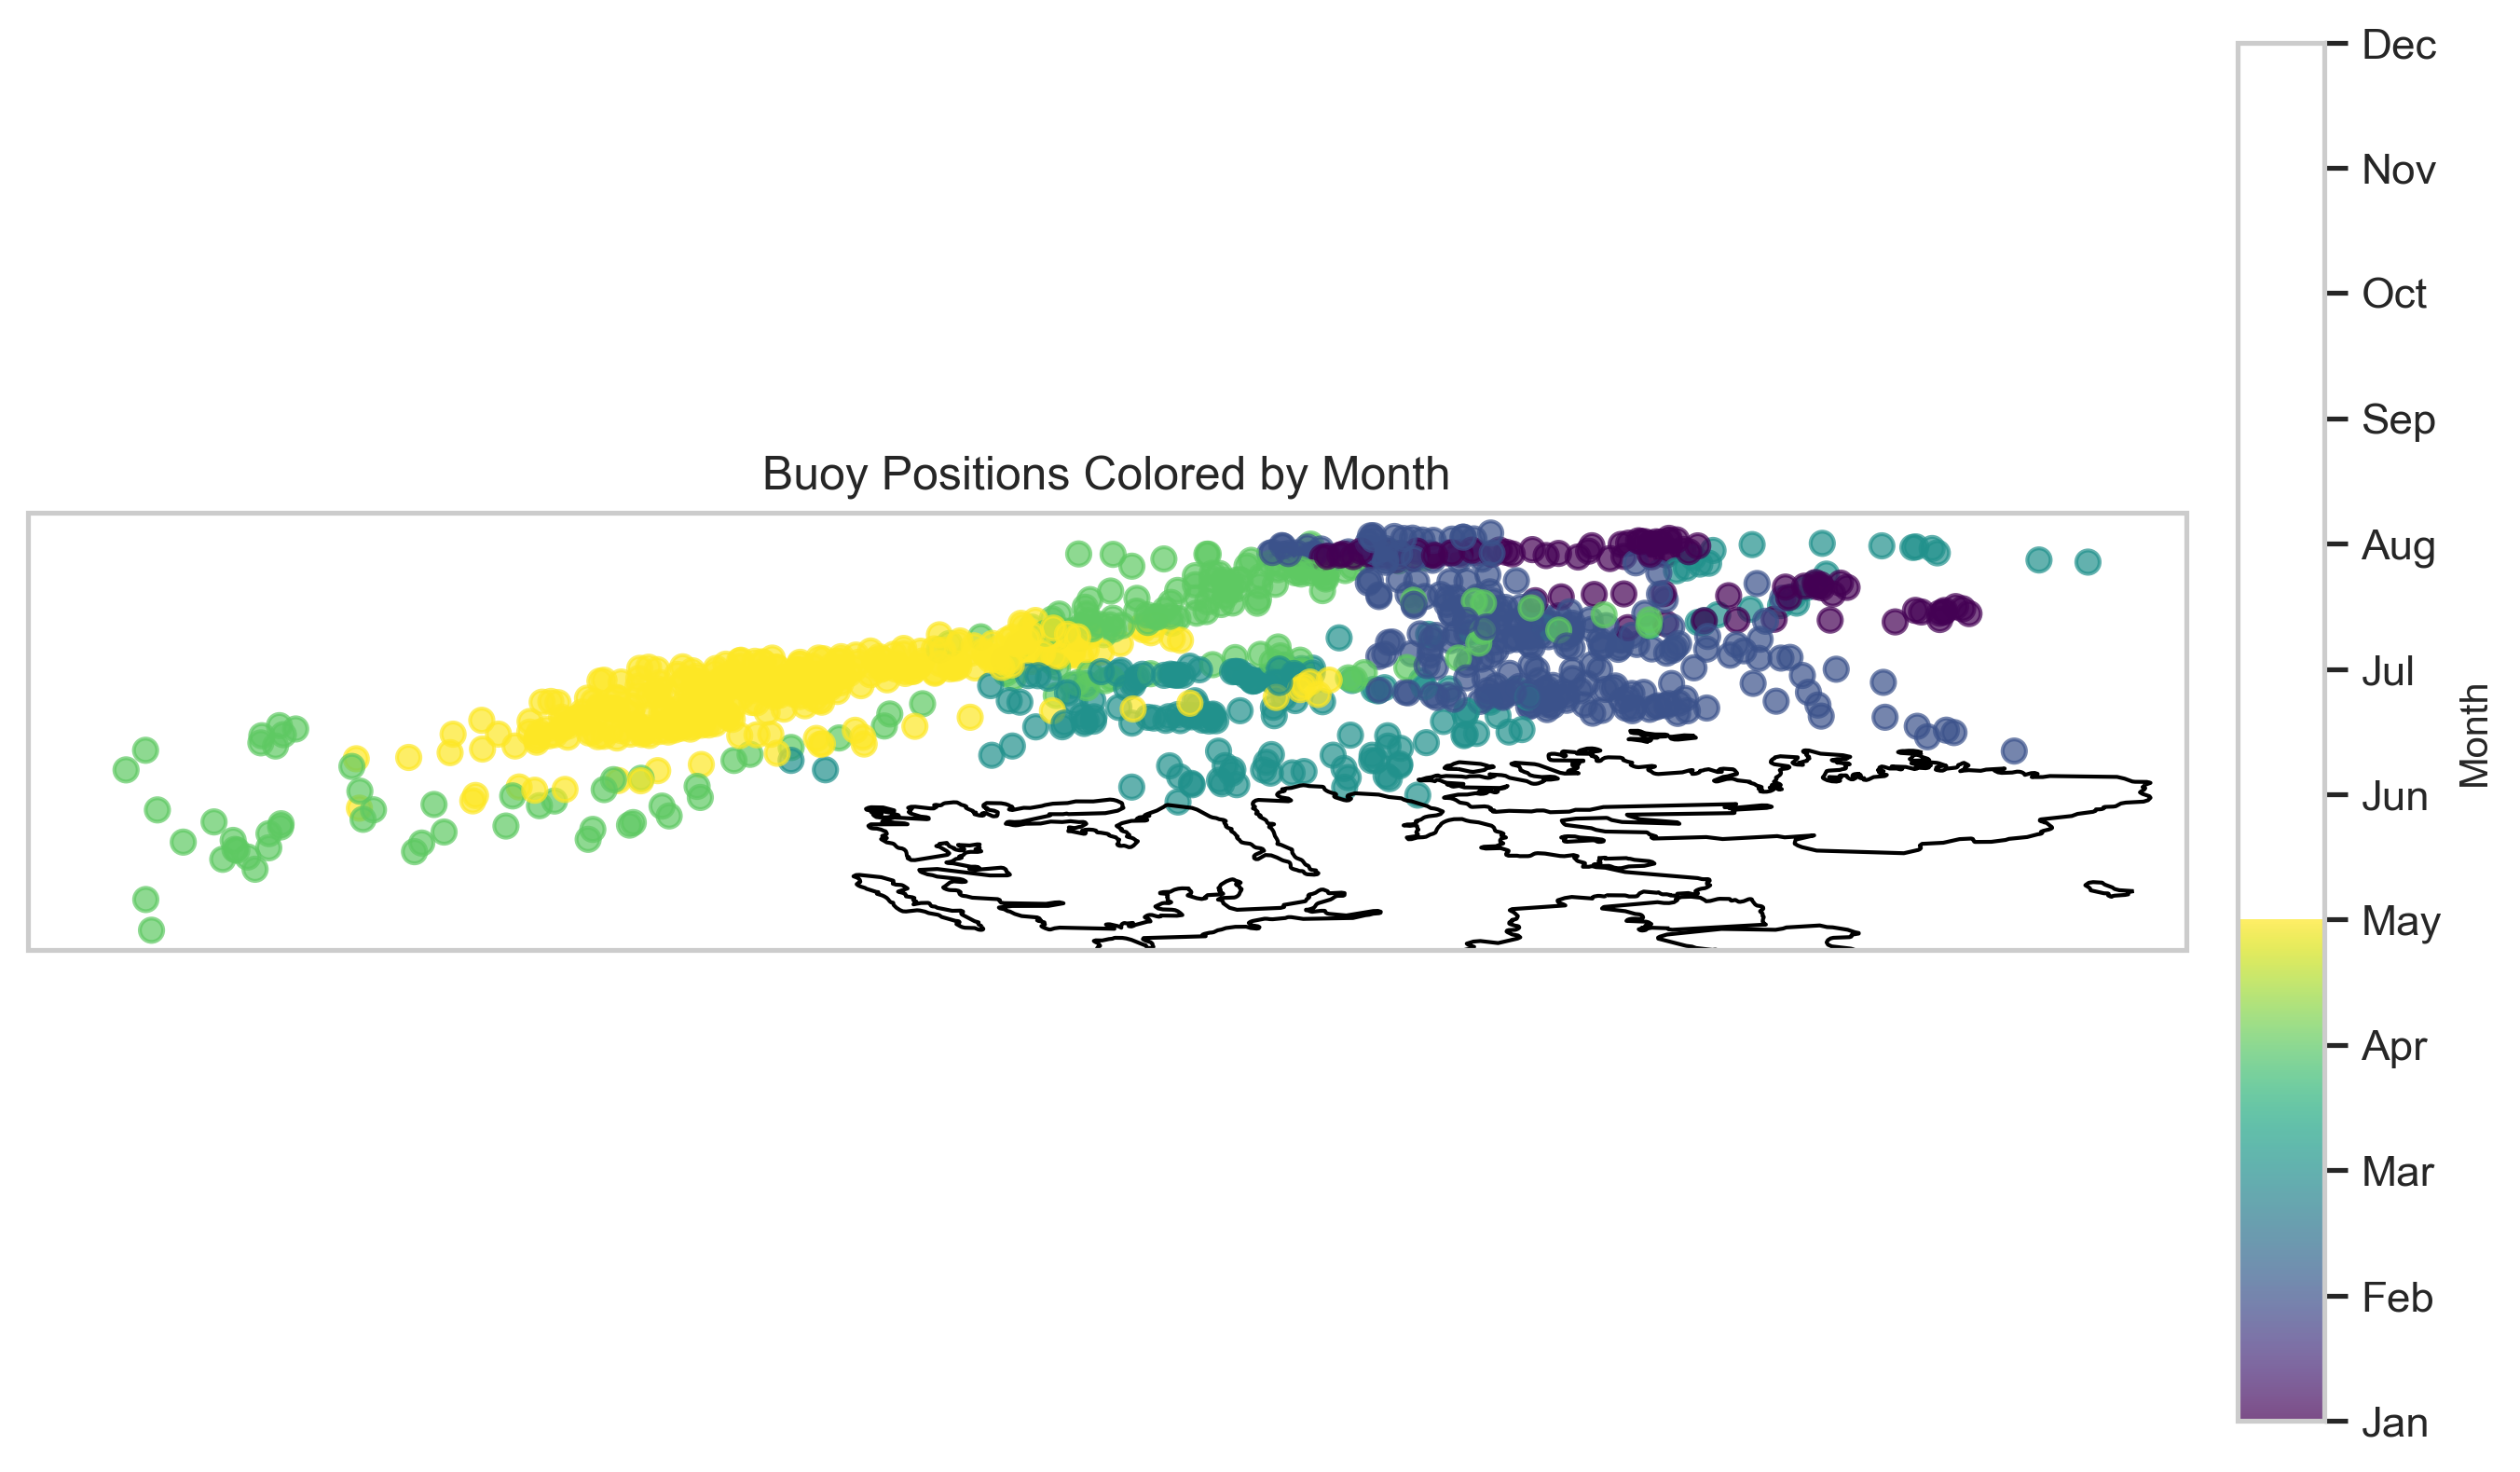

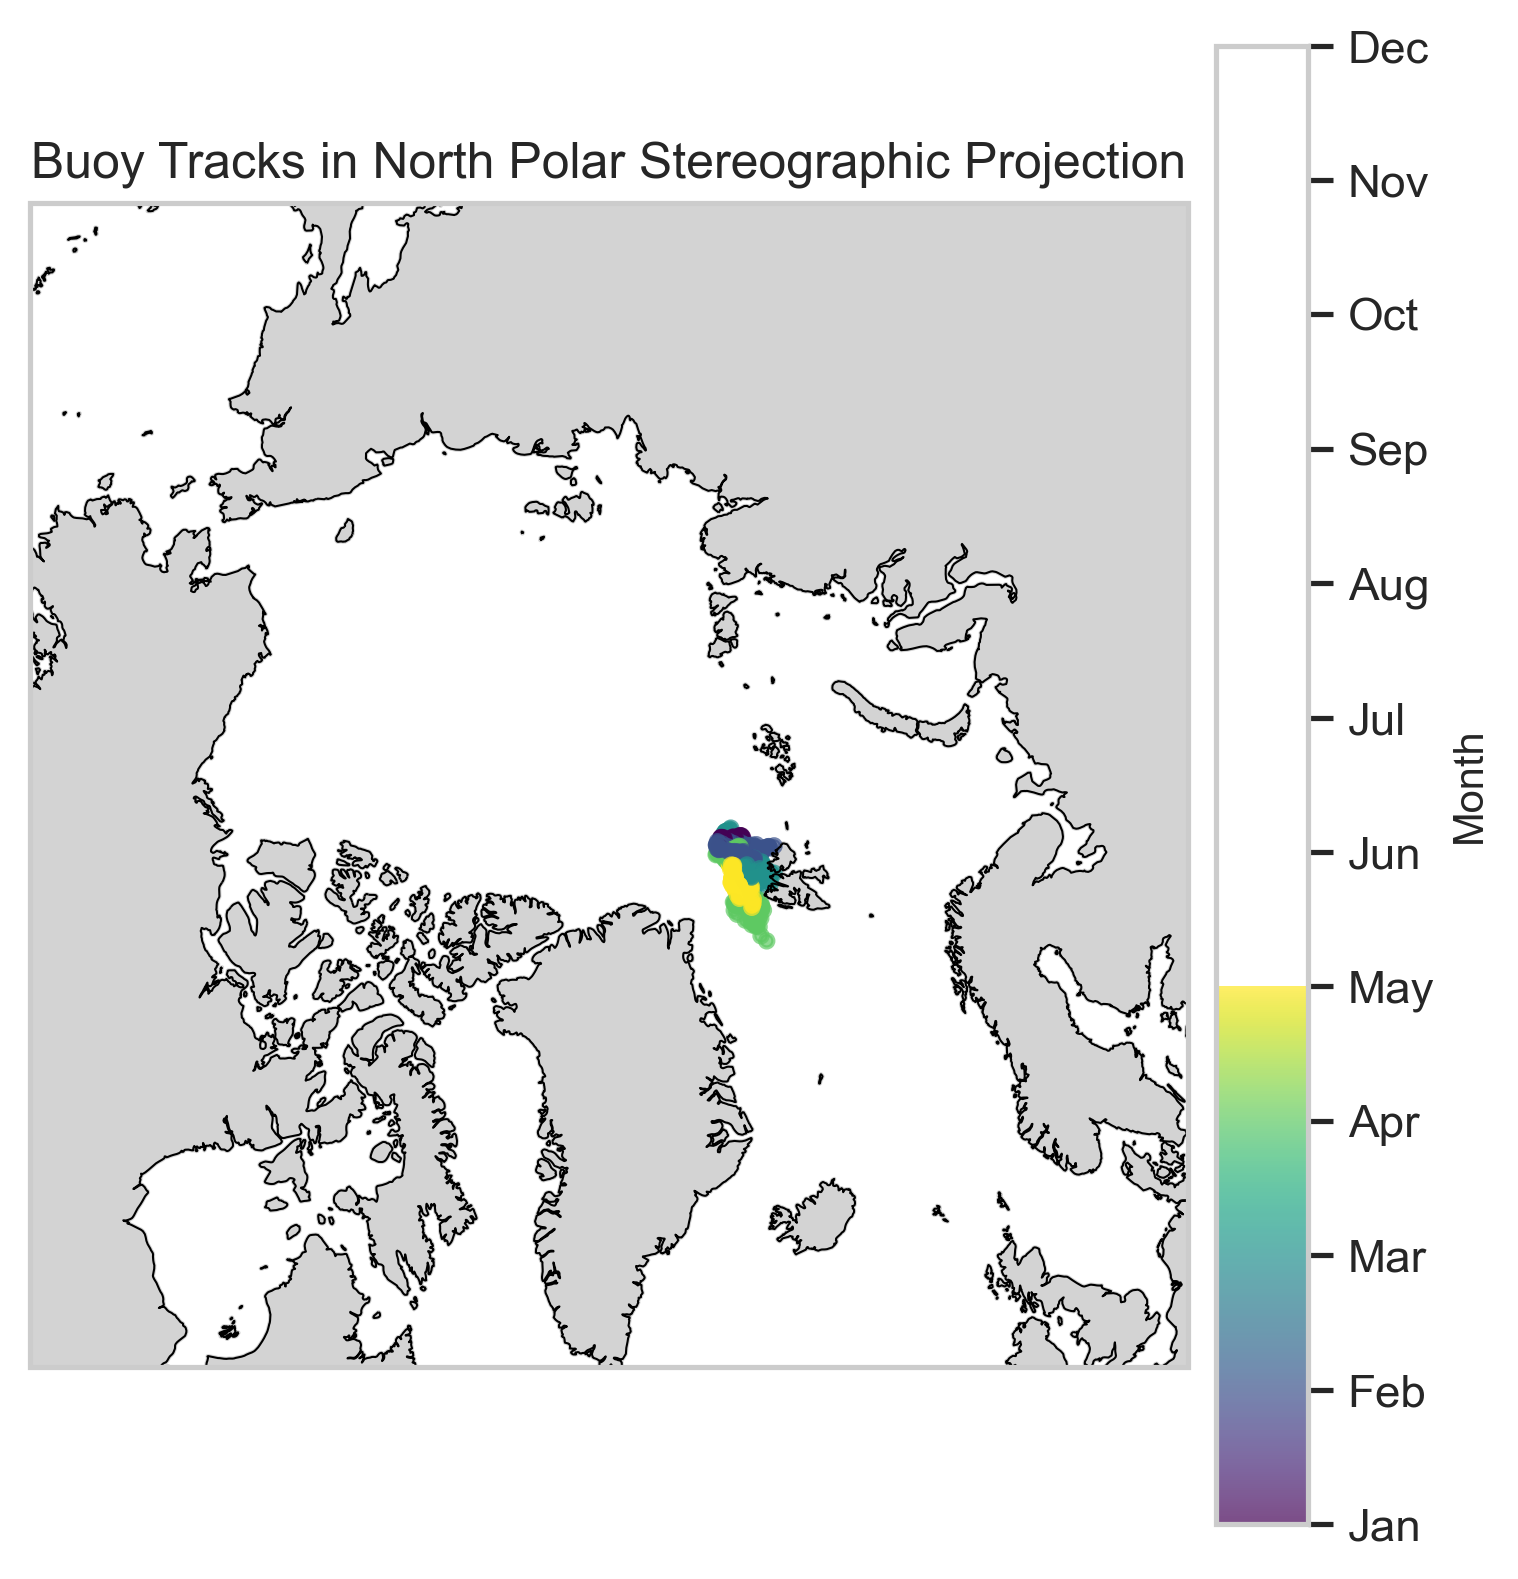

In [59]:
# Example usage
plot_combined_anomalies_and_sic(
    daily_median_anomaly, 
    daily_min_anomaly, 
    daily_max_anomaly, 
    drift_speed_stats, 
    sic_stats, 
    expedition_id='Expedition_ID'
)

plot_monthly_colored_map(
    all_positions_daily, 
    title='Buoy Positions Colored by Month'
)

plot_nps_map(
    all_positions_daily, 
    title='Buoy Tracks in North Polar Stereographic Projection'
)

Detected change points at indices: [1096]


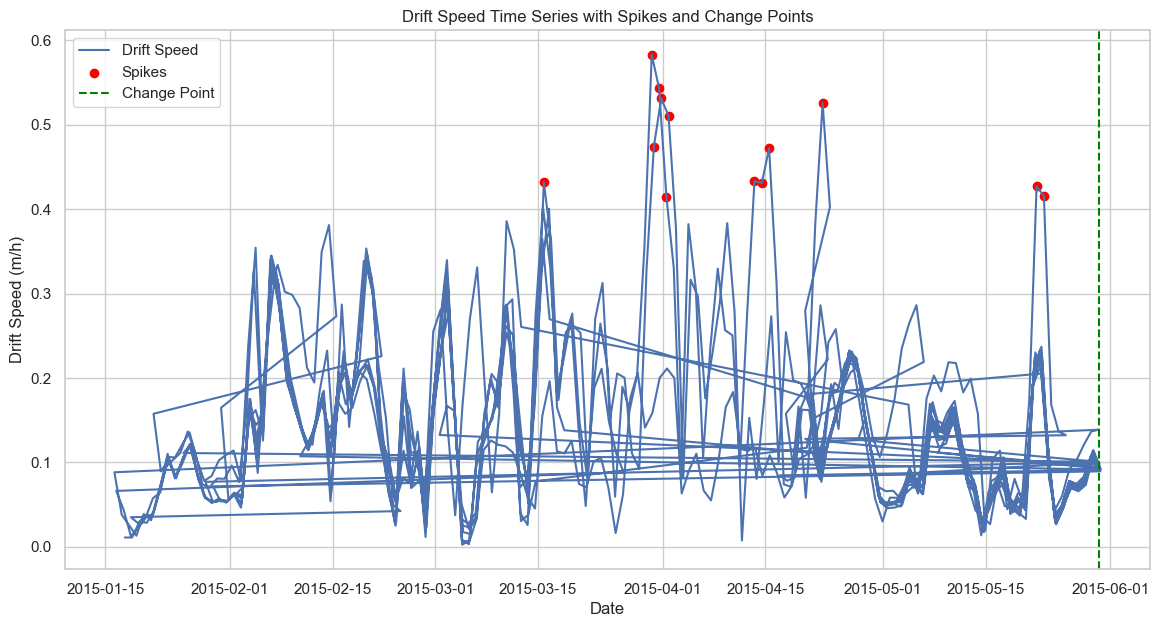

In [60]:
from ruptures import Pelt

# Initialize Pelt algorithm for change point detection
algo = Pelt(model="rbf").fit(all_positions_daily['speed'].values)

# Predict change points with a penalty value (adjust 'pen' as needed)
change_points = algo.predict(pen=10)

print(f"Detected change points at indices: {change_points}")


plt.figure(figsize=(14, 7))
plt.plot(all_positions_daily.index, all_positions_daily['speed'], label='Drift Speed')

# Define a threshold for spikes (e.g., mean + 3*std)
threshold = all_positions_daily['speed'].mean() + 3 * all_positions_daily['speed'].std()
spikes = all_positions_daily[all_positions_daily['speed'] > threshold]

# Highlight spikes
plt.scatter(spikes.index, spikes['speed'], color='red', label='Spikes')

# Mark change points
for cp in change_points:
    plt.axvline(all_positions_daily.index[cp-1], color='green', linestyle='--', label='Change Point' if cp == change_points[0] else "")

plt.xlabel('Date')
plt.ylabel('Drift Speed (m/h)')
plt.title('Drift Speed Time Series with Spikes and Change Points')
plt.legend()
plt.show()



In [61]:
def process_expedition(exp_df, expedition_id):
    """
    Processes buoy data for a single expedition, plotting drift speed anomalies
    and sea ice concentration with compact, high-resolution visuals.
    
    Parameters:
    - exp_df: DataFrame containing buoy data for the expedition
    - expedition_id: Identifier for the expedition
    """
    # Calculate anomalies
    exp_df['rolling_mean_speed'] = exp_df['speed'].rolling(window=24, min_periods=1).mean()
    exp_df['speed_anomaly'] = exp_df['speed'] - exp_df['rolling_mean_speed']
    
    # Daily statistics for speed anomaly
    daily_median_anomaly = exp_df['speed_anomaly'].resample('D').median()
    daily_min_anomaly = exp_df['speed_anomaly'].resample('D').min()
    daily_max_anomaly = exp_df['speed_anomaly'].resample('D').max()
    
    # Drift speed and SIC statistics
    drift_speed_stats = exp_df.groupby(exp_df.index).agg(
        median_speed=('speed', 'median'),
        IQR_lower_speed=('speed', lambda x: x.quantile(0.25)),
        IQR_upper_speed=('speed', lambda x: x.quantile(0.75))
    ).reset_index().rename(columns={'datetime_copy': 'datetime'})
    
    sic_stats = exp_df.groupby(exp_df.index).agg(
        median_sic=('sea_ice_concentration', 'median'),
        IQR_lower_sic=('sea_ice_concentration', lambda x: x.quantile(0.25)),
        IQR_upper_sic=('sea_ice_concentration', lambda x: x.quantile(0.75))
    ).reset_index().rename(columns={'datetime_copy': 'datetime'})
    
    # Create combined figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), dpi=300, sharex=True)

    # Plot Daily Median Anomaly
    ax1.plot(daily_median_anomaly.index, daily_median_anomaly, label='Daily Median Anomaly', color='blue', linewidth=1)
    ax1.fill_between(daily_median_anomaly.index, daily_min_anomaly, daily_max_anomaly, color='gray', alpha=0.3, label='Ensemble Range')
    ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax1.set_ylabel('Speed Anomaly (m/h)', fontsize=8)
    ax1.set_title(f'Daily Median Drift Speed Anomalies - {expedition_id}', fontsize=10)
    ax1.legend(fontsize=6, loc='upper left')
    ax1.tick_params(axis='y', labelsize=6)

    # Plot Median Drift Speed
    ax2.plot(drift_speed_stats['datetime'], drift_speed_stats['median_speed'], label='Median Drift Speed', color='blue', linewidth=1)
    ax2.fill_between(drift_speed_stats['datetime'], drift_speed_stats['IQR_lower_speed'], drift_speed_stats['IQR_upper_speed'], color="gray", alpha=0.3, label='IQR Speed')
    ax2.set_ylabel('Drift Speed (m/h)', fontsize=8)
    ax2.set_title(f'Median Daily Drift Speed with IQR - {expedition_id}', fontsize=10)
    ax2.legend(fontsize=6, loc='upper left')
    ax2.tick_params(axis='y', labelsize=6)

    # Plot Median Sea Ice Concentration
    ax3.plot(sic_stats['datetime'], sic_stats['median_sic'], label='Median SIC', color='red', linewidth=1)
    ax3.fill_between(sic_stats['datetime'], sic_stats['IQR_lower_sic'], sic_stats['IQR_upper_sic'], color="gray", alpha=0.3, label='IQR SIC')
    ax3.set_ylabel('Sea Ice Concentration', fontsize=8)
    ax3.set_title(f'Median Daily Sea Ice Concentration with IQR - {expedition_id}', fontsize=10)
    ax3.legend(fontsize=6, loc='upper left')
    ax3.invert_yaxis()  # Invert y-axis if higher SIC values represent more ice
    ax3.tick_params(axis='y', labelsize=6)

    # Common X-axis label and x-axis settings
    ax3.set_xlabel('Date', fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=6)
    
    # Adjust layout for tight fit
    plt.tight_layout()
    plt.show()
    
    # Plot map with buoy tracks separately
    plot_buoy_map(exp_df, expedition_id)



In [62]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def plot_buoy_map(exp_df, expedition_id):
    """
    Plots the map with buoy tracks for the given expedition using a North Polar Stereographic projection.
    Colors indicate the date, with distinct color coding by month.
    
    Parameters:
    - exp_df: DataFrame containing buoy data for the expedition
    - expedition_id: Identifier for the expedition
    """
    # Define the map projection
    crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70)
    
    # Create a figure with North Polar Stereographic projection
    fig = plt.figure(figsize=(6, 12), dpi=300)  # Increased figure height
    ax = fig.add_subplot(1, 1, 1, projection=crs)
    
    # Extend the map extent to cover a larger north-south area
    ax.set_extent([0.2e6, 1.3e6, -2.5e6, 0.5e6], crs=crs)
    
    # Add land features to the map
    ax.add_feature(cfeature.LAND, color='k')
    
    # Add coastlines for geographic context
    ax.coastlines(resolution='50m', color='white', linewidth=0.5)
    
    # Add gridlines for reference
    gl = ax.gridlines(draw_labels=True, color='gray', linestyle='--', linewidth=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6}
    gl.ylabel_style = {'size': 6}
    
    # Convert 'datetime' to a month-based integer for coloring
    exp_df['month'] = exp_df['datetime'].dt.month
    
    # Set up a distinct colormap for months (1 to 12)
    cmap = cm.get_cmap('tab20', 12)  # 'tab20' provides 20 distinct colors
    norm = mcolors.BoundaryNorm(boundaries=range(1, 14), ncolors=12)
    
    # Plot each point, color-coded by month
    sc = ax.scatter(
        exp_df['longitude'], exp_df['latitude'],
        c=exp_df['month'], cmap=cmap, norm=norm,
        transform=ccrs.PlateCarree(), marker='o', s=5, label='Buoy Track'
    )
    
    # Add a color bar to indicate months
    cbar = plt.colorbar(sc, ax=ax, orientation="vertical", pad=0.05, aspect=30)
    cbar.set_label('Month', fontsize=8)
    cbar.set_ticks(range(1, 13))
    cbar.ax.tick_params(labelsize=6)
    
    # Add title and legend
    plt.title(f'Buoy Track Map - Expedition {expedition_id}', fontsize=10)
    plt.legend(fontsize=6)
    
    # Show the plot
    plt.tight_layout()
    plt.show()




In [63]:
# Check and set up 'datetime' columns for processing
if 'datetime' not in all_positions_daily.columns:
    all_positions_daily.reset_index(inplace=True)
all_positions_daily['datetime_copy'] = all_positions_daily['datetime']
all_positions_daily.set_index('datetime_copy', inplace=True)

# Define and extract expedition IDs if not present
all_positions_daily['expedition_id'] = all_positions_daily['buoy_id'].str.extract(r'cleaned_\d{4}([A-Z]+\d+)', expand=False)
expeditions = all_positions_daily['expedition_id'].dropna().unique()

# Process each expedition by calling `process_expedition`
for exp_id in expeditions:
    exp_df = all_positions_daily[all_positions_daily['expedition_id'] == exp_id].copy()
    process_expedition(exp_df, exp_id)  # `plot_buoy_map` is called within `process_expedition`
